In [88]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
import pandas as pd
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px 
from scipy.optimize import minimize
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

Download data 

In [63]:
Snp = pd.read_csv('Snp.csv')
#Snp = Snp.loc[Snp["strike"] > 3500]
#Snp = Snp.loc[Snp["strike"] < 5500]
St = 4400 #цена актива 
Snp['IVbyNewton'] = 0
r = 0.03
print(Snp['days to expiry'].unique())

[ 12  13  14  15  16  19  20  21  22  23  26  30  33  37  44  51  62  79
  92 107 121 142 170 198 211 233 261 296]


In [64]:
fig = px.scatter_3d(Snp, x='strike', y='days to expiry', z='impliedVolatility', opacity=0.7)
fig.update_layout(
    scene = dict(
        aspectmode = 'manual',
        aspectratio = dict(x = 5, y = 5, z = 3)
    )
)
fig.show()

In [65]:
#Newton Raphson method of implied volatility calculation + nesessary functions
def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r):
    iterate = 200
    bound = 1.0e-5
    sigma = 0.5
    for i in range(0, iterate):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  
        if (abs(diff) < bound):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

find_vol(16.1 ,St, 4555, 12/255, r)

0.16824125242171006

In [ ]:
#траблы...
for i in range(0, len(Snp)):
    V = (Snp['bid'][i] + Snp['ask'][i])/2
    print(V)
    K = Snp['strike'][i]
    print(K)
    T = Snp['days to expiry'][i]/365
    try:
        sigma = find_vol(V, St, K, T, r)
    except:
        sigma = np.nan
    Snp.iloc[i, Snp.columns.get_loc("IVbyNewton")] = sigma 

In [92]:
from csaps import csaps

smile = Snp.loc[Snp["days to expiry"] == 33]
strike = np.array(smile["strike"])
iv = np.array(smile['impliedVolatility'])

xs = np.linspace(min(smile["strike"]),max(smile["strike"]),len(smile["strike"]))
ys = csaps(smile["strike"],smile['impliedVolatility'], xs, smooth=0.000001)

fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=ys, mode = 'lines'))
fig.add_trace(go.Scatter(x=strike, y=iv, mode = 'markers', marker = dict(color='red', size = 10)))
    
fig.update_layout(
    width=800,
    height=600
    )
fig.show()

## The optimization problem for the miltiperioud SVI

\begin{aligned}
&(NLP): \min_{x \in \mathbb{R}^5} f(k; x_R) \\
&\text{subject to} \\
& a_d \leq a \leq a_u, \\
& b_d \leq b \leq b_u, \\
& \rho_d < \rho < \rho_u, \\
& m_d \leq m \leq m_u, \\
& \sigma_d \leq \sigma \leq \sigma_u, \\
& g(k; x_R) \geq \varepsilon, \\
& \frac{\partial w(k, T)}{\partial T} \geq \varepsilon, \quad \forall k \in \mathbb{R}, T > 0, \varepsilon > 0
\end{aligned}


In [70]:
#Arbitrage free SVI model: 
class SVI: #вроде работает 

    def __init__(self):
        
        self.St = 4400
        self.df = Snp
        self.surface = None 
        self.params = {}

    '''
    ВНЕШНЯЯ ФУНКЦИЯ
    '''

    def smile_optimization(self): 
        strikes = np.linspace(-0.02,0.02,20) #мб надо менять динамически! 
        maturities = (self.df['days to expiry'].unique()) #экспирация в годах 

        for i in range(0, len(maturities)): #счетчик 
            
            t = maturities[i] #дни 
            Ft = self.St * np.exp(1.05 * (t / 365)) #доля года 
            
            slice_ = self.df.loc[(self.df["days to expiry"] == t)]
            y = np.array(slice_.impliedVolatility)
            k = np.array(np.log(slice_.strike / Ft))

            bnds =  ((-1, max(y)), (0, 1), (-1, 1), (2 * min(k), 2 * max(k)), (None, None))
            initial_params = [max(y)/2, 0.1, -0.5, 0, 0.1]

            #Adding constraints of non crossing slices (for the first step there are no calendar bounds)
            con1 = {'type': 'ineq', 'fun': lambda x: self.dencity(x, k)} #restriction on Durrelman condation
            if i == 0: 
                cons = ([con1])
            else:
                print(self.params[maturities[i-1]])
                con2 = {'type': 'ineq', 'fun': lambda x: self.SVI_function(self.params[maturities[i - 1]], k) - self.SVI_function(x, k)}
                cons = ([con1,con2])

            #result = minimize(self.objective_func, initial_params, args=(k, y, t), method='SLSQP', bounds=bnds, constraints=cons)
            result = minimize(self.objective_func, initial_params, args=(k, y, (t/360)), method='SLSQP', bounds=bnds)
            self.params[t] = result.x
            
            print(result.x)
            
    '''
    ВНУТРЕННИЕ ФУНКЦИИ
    '''
    def SVI_function(self, params, strikes):
        a, b, rho, m, sigma = params
        return a + b * (rho * (strikes - m) + np.sqrt((strikes - m) ** 2 + sigma ** 2))

    def objective_func(self, params, strikes, implied_vols, maturity):
        totalvols = implied_vols * maturity #сделал adjustment на total variance.
        model_vols = self.SVI_function(params, strikes)
        return np.sum((model_vols - totalvols) ** 2)

    def dencity(self, params, strikes): 
        a, b, rho, m, sigma = params
        w = a + b * (rho * (strikes - m) + np.sqrt((strikes - m) ** 2 + sigma ** 2))
        dw = b * rho + ((1/(np.sqrt((strikes - m)**2 + sigma**2))) * (b * (strikes - m)))
        ddw = (b * (sigma**2)) / ((np.sqrt((strikes - m)**2 + sigma**2)) * ((strikes - m)**2 + sigma**2))
        g = (1 - (strikes * dw)/(2*w))**2 - ((dw**2)/4)*(1/dw + 1/4) + (ddw/2)
        return g 

    def plot_smile(self, maturity):
        strikes = np.linspace(-0.3,0.3,60)
        y_hat = self.SVI_function(self.params[maturity], strikes)

        Ft = self.St * np.exp(1.05 * (maturity / 365))
        slice_ = self.df.loc[(self.df["days to expiry"] == maturity)]
        y = np.array(slice_.impliedVolatility) * (maturity / 365)
        k = np.array(np.log(slice_.strike / Ft))

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=strikes, y=y_hat, mode = 'lines'))
        fig.add_trace(go.Scatter(x=k, y=y, mode = 'markers', marker = dict(color='red', size = 10)))
    
        fig.update_layout(
            width=800,
            height=600
        )
        fig.show()


In [71]:
m = SVI()

In [72]:
m.smile_optimization()

[-0.00159222  0.07178686 -0.49966596 -0.01058579  0.07536183]
[-0.00159222  0.07178686 -0.49966596 -0.01058579  0.07536183]
[-0.00405022  0.0890073  -0.49984642 -0.00506583  0.08952793]
[-0.00405022  0.0890073  -0.49984642 -0.00506583  0.08952793]
[-0.00282908  0.08529402 -0.49969419 -0.00769592  0.08577621]
[-0.00282908  0.08529402 -0.49969419 -0.00769592  0.08577621]
[-0.0039311   0.0922063  -0.49992355 -0.00439545  0.09279005]
[-0.0039311   0.0922063  -0.49992355 -0.00439545  0.09279005]
[-0.01546766  0.09697138 -0.49893376 -0.0304688  -0.22843583]
[-0.01546766  0.09697138 -0.49893376 -0.0304688  -0.22843583]
[-0.00211298  0.08664777 -0.49955134 -0.00908829  0.08834127]
[-0.00211298  0.08664777 -0.49955134 -0.00908829  0.08834127]
[-0.00137846  0.09399118 -0.50014309 -0.05431124  0.09359166]
[-0.00137846  0.09399118 -0.50014309 -0.05431124  0.09359166]
[-0.00160596  0.0881724  -0.49972412 -0.00725986  0.09081277]
[-0.00160596  0.0881724  -0.49972412 -0.00725986  0.09081277]
[ 0.0021

In [93]:
m.plot_smile(33)

## Local estimator regression

In [80]:
St = 4400 #цена актива в момент снятия датасета 

# set variabels - devide dataframe into trainig and testing dataset 

target = 'impliedVolatility'
features = ['strike', 'days to expiry']
X, y = Snp[features].values, Snp[target].values
Snp.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,volume,openInterest,impliedVolatility,currency,Expiry Date,days to expiry,IVbyNewton
0,SPXW230911C04460000,2023-08-30 14:45:33+00:00,4460,68.30,75.1,77.4,3.500000,107,211,0.132302,USD,2023-09-11,12,0.317388
1,SPXW230911C04470000,2023-08-30 16:18:32+00:00,4470,69.00,68.0,69.6,14.830002,207,223,0.128686,USD,2023-09-11,12,0.306073
2,SPXW230911C04500000,2023-08-30 19:22:14+00:00,4500,43.76,46.5,47.4,5.099998,971,1379,0.116433,USD,2023-09-11,12,0.268768
3,SPXW230911C04515000,2023-08-30 19:58:39+00:00,4515,34.65,37.0,38.0,4.700001,68,70,0.111955,USD,2023-09-11,12,0.251574
4,SPXW230911C04520000,2023-08-30 19:57:03+00:00,4520,30.77,34.2,35.2,2.650000,65,711,0.110849,USD,2023-09-11,12,0.246471


In [81]:
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

In [82]:
class LocalRegression(BaseEstimator):
    
    def __init__(self, model, kernel_size: int=1):
        self.model = model
        self.kernel_size = kernel_size

    def fit(self, X: np.ndarray, y: np.array = None) -> 'LocalRegression':
        self.X, self.y = X, y
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict_proba)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict)

    def __predict(self, X: np.ndarray, fnc) -> np.ndarray:
        result = []
        for i in range(X.shape[0]):
            self.model.fit(
                self.X, self.y,
                sample_weight=self.__tri_cube_kernel(X[i:i + 1, :]))
            result.append(np.atleast_2d(fnc([X[i]])))
        return np.vstack(result)

    def __tri_cube_kernel(self, x0):
        points_cnt = self.kernel_size
        if points_cnt <= 1:
            points_cnt = int(self.X.shape[0] * points_cnt)
        distances = cdist(self.X, x0)
        kernel_points_indices = np.argpartition(
            distances, points_cnt, axis=0)[:points_cnt]
        max_distance = np.max(distances[kernel_points_indices])
        relative_distance = distances/max_distance
        result = (relative_distance <= 1)*(1-relative_distance**3)**3
        return np.squeeze(result)

In [83]:
local_regression = LocalRegression(model=LinearRegression(), kernel_size=50).fit(X, y)

In [84]:
X0I, X1I = np.meshgrid(np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 25), np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 25))

y_hat = local_regression.predict(np.vstack((np.atleast_2d(X0I.flatten()), np.atleast_2d(X1I.flatten()))).T)

YI = y_hat.reshape((X0I.shape[0], -1))

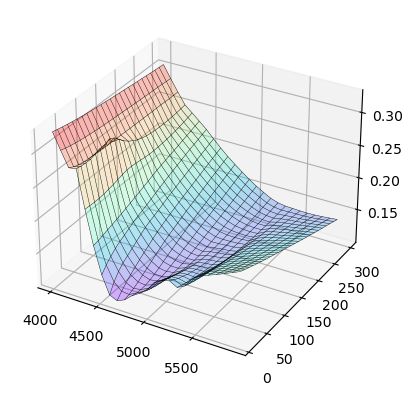

In [91]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(1, 1, N)
newcmp = ListedColormap(vals)

plt.get_cmap('rainbow')
ax = plt.axes(projection ="3d")
ax.plot_surface(X0I, X1I, YI, cmap='rainbow', alpha = 0.3,shade=False)
_ = ax.plot_wireframe(X0I, X1I, YI, cmap='rainbow', linewidth=0.3, color='black')